# Penerapan Algoritma Support Vector Machine dalam Klasifikasi Buah Busuk Berdasarkan Fitur Visual pada Citra Buah 
#### Anggota:

1. Muhammad Rafi (F1D022015)
2. Muhammad Aryan Fathurrahman (F1D022069)
3. Nurul Fatimah (F1D022085)
4. Zelena Intan Mardita (F1D022103)
5. Rafa Maulana Rahman (F1D022153)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import os
from skimage.feature import graycomatrix, graycoprops
import csv



## Load Data

Function yang dideklarasikan di bawah ini digunakan untuk load data

In [2]:

def write_images_and_labels(image, filename:str, folder_path:str, folder_title:str=None):
    path = folder_path
    if folder_title is not None:
        path = os.path.join(folder_path, folder_title)
        os.makedirs(path, exist_ok=True)
    cv2.imwrite(os.path.join(path, filename), image)

def crop(image):
    height, width = image.shape[:2]

    # Determine the minimum dimension to create a square crop
    min_dimension = min(width, height)

    # Calculate cropping box (left, upper, right, lower)
    left = (width - min_dimension) // 2
    upper = (height - min_dimension) // 2
    right = left + min_dimension
    lower = upper + min_dimension

    # Crop the image to the calculated box
    cropped_img = image[upper:lower, left:right]
    return cropped_img

def resize_raw_data(folder_path:str, output_path:str):

    images = {label: [] for label in os.listdir(folder_path)}

    for folders in os.listdir(folder_path):
        for files in os.listdir(os.path.join(folder_path, folders)):
            filename = os.path.basename(files)
            image = cv2.imread(os.path.join(folder_path, folders, files), cv2.IMREAD_COLOR)
            # image = crop(image)
            image = cv2.resize(image, (150, 150))
            images[folders].append(image)
            write_path = output_path or os.path.join(folder_path, 'resized')
            write_images_and_labels(image, filename,  write_path, folders)

def load_processed_data(folder_path) -> dict:
    images = {label: [] for label in os.listdir(folder_path)}
    for folders in os.listdir(folder_path):
        for files in os.listdir(os.path.join(folder_path, folders)):
            image = cv2.imread(os.path.join(folder_path, folders, files))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images[folders].append(image)

    return images

def show_random_images(images: dict,label:str, amount:int = 5):
    plt.figure(figsize=(15, 5))
    sample = np.random.randint(0, len(images[label]), amount)
    for i, index in enumerate(sample):
        plt.suptitle(f'Label: {label}')
        plt.subplot(1, amount, i + 1)
        plt.imshow(images[label][index])
        plt.axis('off')
    plt.show()

In [79]:
resize_raw_data('../dataset/', '../resized')

In [3]:
images = load_processed_data('../resized')

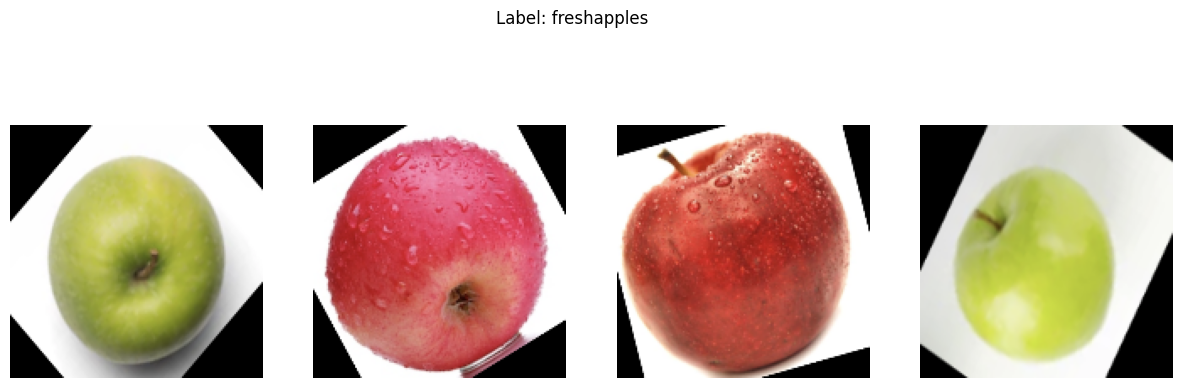

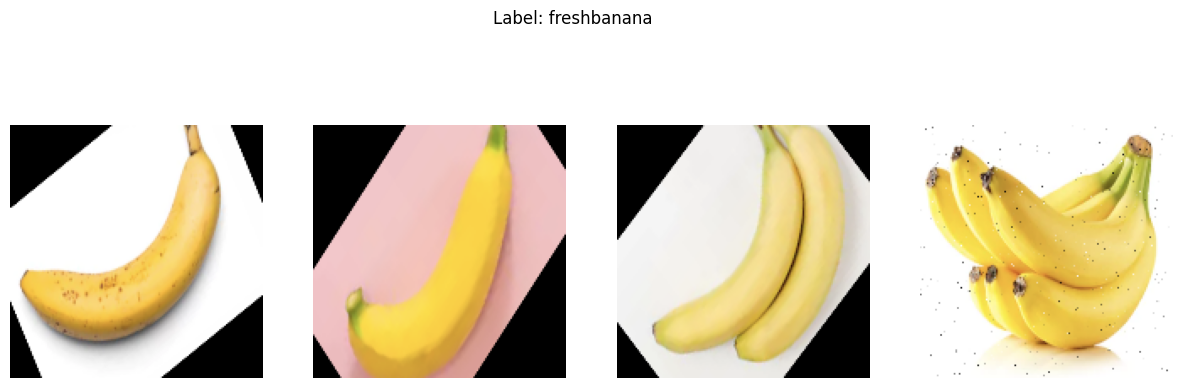

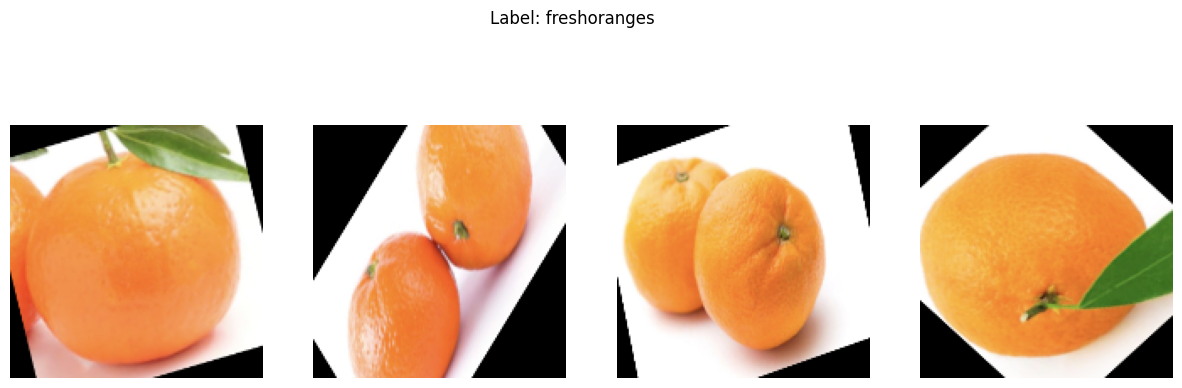

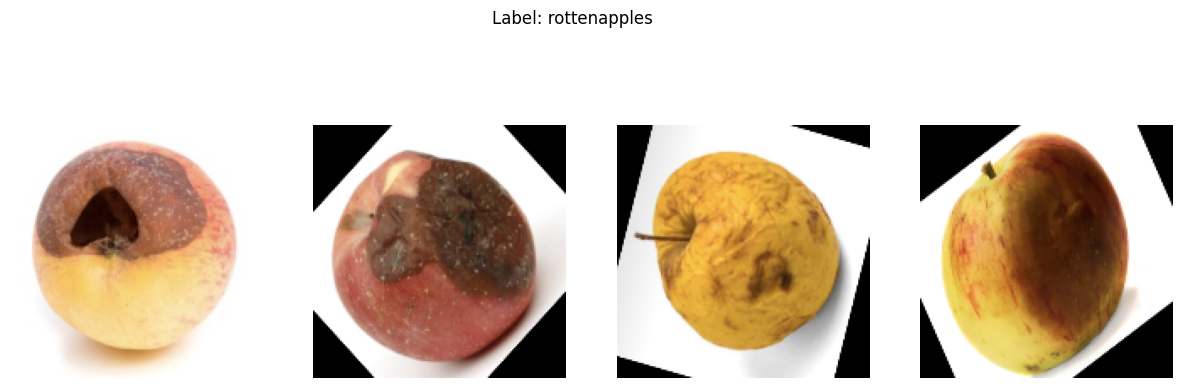

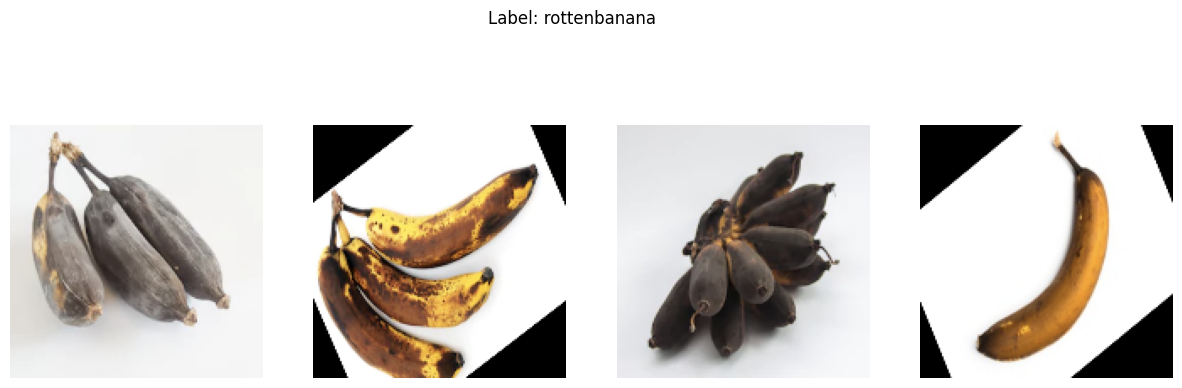

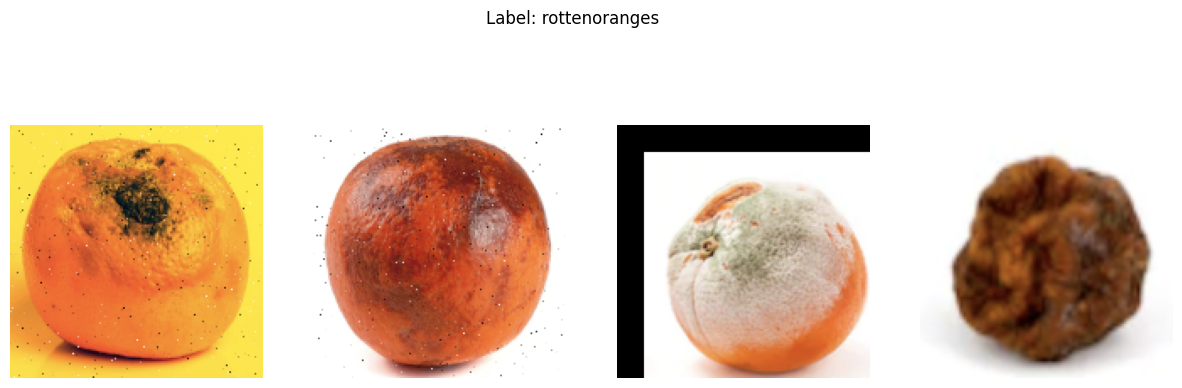

In [4]:
for label in images.keys():
    show_random_images(images, label, 4)

## 1. No Preprocessing

#### Feature Extraction : GLCM

In [5]:
def calculate_glcm(edge_image, angles = [0], distances = [1], symmetric = True):
    glcm_matrices = []
    
    for angle in angles:
        for distance in distances:
            glcm = np.zeros((256, 256))
            rows, cols = edge_image.shape[:2]

            for i in range(rows):
                for j in range(cols):
                    current_pixel = edge_image[i, j]
                    neighbor_pixel_x = i + distance * np.cos(np.radians(angle))
                    neighbor_pixel_y = j - distance * np.sin(np.radians(angle))

                    if 0 <= neighbor_pixel_x < rows and 0 <= neighbor_pixel_y < cols:
                        neighbor_pixel = edge_image[int(neighbor_pixel_x), int(neighbor_pixel_y)]
                        glcm[current_pixel, neighbor_pixel] += 1
                        
                        if symmetric:
                            glcm[neighbor_pixel, current_pixel] += 1

            glcm_matrices.append(glcm)
    # print(glcm_matrices)
    
    return glcm_matrices

In [6]:


def calculate_glcm_features(glcm_matrices):
    features = {'contrast':[], 'dissimilarity':[], 'homogeneity':[], 'energy':[], 'correlation':[], 'entropy':[], 'asm':[]}
    for glcm_matrix in glcm_matrices:
        print(glcm_matrix)
        glcm_matrix_normalized = glcm_matrix / np.sum(glcm_matrix)
        
        i, j = np.meshgrid(np.arange(glcm_matrix.shape[0]), np.arange(glcm_matrix.shape[1]), indexing='ij')
        mean_value = np.sum(glcm_matrix_normalized * (i + j))
        
        contrast = np.sqrt(np.sum(glcm_matrix_normalized * ((i - mean_value)**2 + (j - mean_value)**2)))
        
        # contrast = np.sum(glcm_matrix_normalized * np.square(np.arange(glcm_matrix.shape[0]) - np.arange(glcm_matrix.shape[1])))
        dissimilarity = np.sum(glcm_matrix_normalized * np.abs(np.arange(glcm_matrix.shape[0]) - np.arange(glcm_matrix.shape[1])))
        
        
        homogeneity = np.sum(glcm_matrix_normalized / (1 + np.square(np.arange(glcm_matrix.shape[0]) - np.arange(glcm_matrix.shape[1]))))
        energy = np.sum(np.square(glcm_matrix_normalized))
        correlation = np.sum((np.arange(glcm_matrix.shape[0]) - np.mean(glcm_matrix_normalized)) * 
                             (np.arange(glcm_matrix.shape[1]) - np.mean(glcm_matrix_normalized)) * glcm_matrix_normalized / 
                             (np.std(glcm_matrix_normalized) ** 2))
        entropy = -np.sum(glcm_matrix_normalized * np.log(glcm_matrix_normalized + 1e-10))
        asm = np.sum(np.square(glcm_matrix_normalized))
        
        features['contrast'].append(contrast)
        features['dissimilarity'].append(dissimilarity)
        features['homogeneity'].append(homogeneity)
        features['energy'].append(energy)
        features['correlation'].append(correlation)
        features['entropy'].append(entropy)
        features['asm'].append(asm)
    return features

In [96]:

def extract(image, distance=[1], angles=[0]):
    glcm_result = graycomatrix(image, distance, angles, 256, symmetric=True)
    
    contrast = graycoprops(glcm_result, 'contrast')[0][0]
    dissimilarity = graycoprops(glcm_result, 'dissimilarity')[0][0]
    homogeneity = graycoprops(glcm_result, 'homogeneity')[0][0]
    energy = graycoprops(glcm_result, 'energy')[0][0]
    correlation = graycoprops(glcm_result, 'correlation')[0][0]
    asm = graycoprops(glcm_result, 'ASM')[0][0]
    
    return contrast, dissimilarity, homogeneity, energy, correlation, asm
    

In [92]:
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

grayscaled = {label: [] for label in images.keys()}

for label in images.keys():
    for image in images[label]:
        grayscaled[label].append(grayscale(image))

In [99]:
distance = [1]
angles = [0]

features = { label : [] for label in grayscaled.keys() }

for label in features.keys():
    dataset_extracted_features = {'contrast':0, 'dissimilarity':0, 'homogeneity':0, 'energy':0, 'correlation':0,  'asm':0}
    
    for image in grayscaled[label]:
        contrast, dissimilarity, homogeneity, energy, correlation, asm = extract(image, distance, angles)
        
        dataset_extracted_features['contrast'] = contrast
        dataset_extracted_features['dissimilarity'] = dissimilarity
        dataset_extracted_features['homogeneity'] = homogeneity
        dataset_extracted_features['energy'] = energy
        dataset_extracted_features['correlation'] = correlation
        dataset_extracted_features['asm'] = asm
    features[label].append(dataset_extracted_features)
    
features['freshapples'][0]['contrast']

30.818791946308725

In [105]:
extracted_features = {'contrast':[], 'dissimilarity':[], 'homogeneity':[], 'energy':[], 'correlation':[],  'asm':[]}
for label in grayscaled.keys():
    for image in grayscaled[label]:
        contrast, dissimilarity, homogeneity, energy, correlation, asm = extract(image, distance, angles)
        extracted_features['contrast'].append(contrast)
        extracted_features['dissimilarity'].append(dissimilarity)
        extracted_features['homogeneity'].append(homogeneity)
        extracted_features['energy'].append(energy)
        extracted_features['correlation'].append(correlation)
        extracted_features['asm'].append(asm)
dataframe_extracted_features = pd.DataFrame(extracted_features)
dataframe_extracted_features.to_csv('../extracted_features.csv', index=False)
dataframe_extracted_features

,contrast,dissimilarity,homogeneity,energy,correlation,asm
0,505.211141,6.205503,0.554577,0.328683,0.972219,0.108032
1,427.687785,5.413244,0.550460,0.254629,0.971555,0.064836
2,399.712170,5.358971,0.487944,0.253376,0.965034,0.064199
3,360.568277,4.401119,0.562796,0.306481,0.965843,0.093931
4,303.435168,5.529843,0.448599,0.182669,0.975129,0.033368
...,...,...,...,...,...,...
1195,200.965727,8.067383,0.376370,0.264464,0.966479,0.069941
1196,180.618926,7.454362,0.378017,0.238049,0.948048,0.056667
1197,174.956913,7.272617,0.418954,0.299039,0.982293,0.089424
1198,178.136107,8.123579,0.326938,0.055625,0.941911,0.003094


In [73]:
# menulis file csv
dataframe = pd.DataFrame(dataset_extracted_features)
dataframe.to_csv('../extracted_features.csv', index=False)

In [107]:
# membaca file csv
df = pd.read_csv('../extracted_features.csv')
loaded_csv = df.to_dict('list')



## Feature Selection

In [77]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def perform_pca_feature_selection(data, n_components=None):
    """
    Perform PCA (Principal Component Analysis) for feature selection.

    Parameters:
    - data: Input data as a 2D array or dataframe (samples x features).
    - n_components: Number of principal components to retain (default is None).

    Returns:
    - reduced_data: Transformed data with reduced dimensions based on PCA.
    - pca_model: Trained PCA model.
    """
    # Standardize the data (mean=0 and variance=1)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Initialize PCA
    pca = PCA(n_components=n_components)
    
    # Perform PCA
    reduced_data = pca.fit_transform(scaled_data)
    
    # Explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    print(f'Explained variance ratio: {explained_variance_ratio}')
    
    # Return reduced data and PCA model
    return reduced_data, pca

In [111]:
prepared_data = pd.DataFrame(loaded_csv).to_numpy()

reduced_data, pca_model = perform_pca_feature_selection(prepared_data, n_components=0.95)


Explained variance ratio: [0.46654904 0.33319885 0.11206723 0.07086218]


In [81]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

y = [label for label in grayscaled.keys()]



label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(reduced_data, y, test_size=0.2, random_state=42)